In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
labels_per_class = 'full' # full

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_MNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Network architecture

In [8]:
dims = (28,28,1)
n_components= 2

In [9]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

### Test model with just UMAP

In [10]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [11]:
min_dist = 0.001
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9290735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.79150456>)

##### build iterator

In [12]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [13]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    #y=Y_masked,
    n_neighbors=n_neighbors,
)

In [14]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 60000])
batch_size

50000

In [15]:
negative_sample_rate = 5

In [16]:
from umap.spectral import spectral_layout

from sklearn.utils import check_random_state

random_state = check_random_state(None)
metric = "euclidean"
_metric_kwds = {}
def init_embedding_from_graph(_raw_data, graph, n_components, random_state, metric, _metric_kwds, init="spectral"):
        """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
        if isinstance(init, str) and init == "random":
            embedding = random_state.uniform(
                low=-10.0, high=10.0, size=(graph.shape[0], n_components)
            ).astype(np.float32)
        elif isinstance(init, str) and init == "spectral":
            # We add a little noise to avoid local minima for optimization to come

            initialisation = spectral_layout(
                _raw_data,
                graph,
                n_components,
                random_state,
                metric=metric,
                metric_kwds=_metric_kwds,
            )
            expansion = 10.0 / np.abs(initialisation).max()
            embedding = (initialisation * expansion).astype(
                np.float32
            ) + random_state.normal(
                scale=0.0001, size=[graph.shape[0], n_components]
            ).astype(
                np.float32
            )

        else:
            init_data = np.array(init)
            if len(init_data.shape) == 2:
                if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                    tree = KDTree(init_data)
                    dist, ind = tree.query(init_data, k=2)
                    nndist = np.mean(dist[:, 1])
                    embedding = init_data + random_state.normal(
                        scale=0.001 * nndist, size=init_data.shape
                    ).astype(np.float32)
                else:
                    embedding = init_data

        return embedding

In [17]:
embedding_init = init_embedding_from_graph(X_train, graph, n_components, random_state, metric, _metric_kwds, init="spectral")

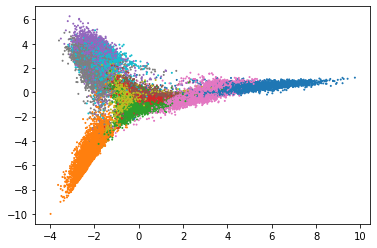

In [18]:
plt.scatter(embedding_init[:,0], embedding_init[:,1], c=Y_train, s=1, cmap=plt.cm.tab10)

#### Build network

In [73]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    
    weights_tiled = np.tile(weight, negative_sample_rate + 1)
    
    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        ce_loss = ce_loss * weights_tiled
        #ce_loss = ce_loss * alpha
        #return tf.reduce_mean(ce_loss)
        return ce_loss

    return loss

In [74]:
def make_gen_callable(n_edges, batch_size):
    def edge_generator():
        while True:
            yield tf.zeros(1, dtype=tf.int32), tf.zeros(1, dtype=tf.int32)

    return edge_generator

In [75]:
n_edges = len(head)
n_edges

1029620

In [76]:
gen = make_gen_callable(n_edges, batch_size)

In [77]:
edge_iter = tf.data.Dataset.from_generator(gen, (tf.float32, tf.int32))

### initialize embedding

In [78]:
from tensorflow.keras.layers import Input

In [79]:
n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([embedding_init])
encoder = tf.keras.Sequential([embedding_layer])

In [80]:
batch_size = len(head)

In [81]:
to_ = tf.constant(tf.expand_dims(head,0))
from_ = tf.constant(tf.expand_dims(tail, 0))

In [82]:
to_.shape

TensorShape([1, 1029620])

In [83]:
batch_sample = Input(shape=(1), dtype=tf.float32, name = "to_x")

to_x = tf.squeeze(tf.gather(to_, tf.cast(batch_sample, tf.int32)[0]))
from_x = tf.squeeze(tf.gather(from_, tf.cast(batch_sample, tf.int32)[0]))

embedding_to = encoder(to_x)[:,-1,:]
embedding_from = encoder(from_x)[:,-1,:]

embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)

model = tf.keras.Model(
    inputs=[batch_sample],
    outputs=[embedding_to_from],#[embedding_to_from],
)

In [84]:
embedding_to_from

<tf.Tensor 'umap/umap_3/Identity:0' shape=(1029620, 4) dtype=float32>

In [85]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    loss=umap_loss(batch_size, negative_sample_rate, _a, _b),
)

#### train

In [ ]:
history = model.fit(
    edge_iter,
    epochs=25,
    steps_per_epoch = 100,
    max_queue_size = 5,
    #use_multiprocessing=True, 
    #workers = -1,
)

Epoch 1/25
100/100 [==============================] - 15s 146ms/step - loss: 0.0377
Epoch 2/25
100/100 [==============================] - 14s 141ms/step - loss: 0.0358
Epoch 3/25
100/100 [==============================] - 14s 141ms/step - loss: 0.0348
Epoch 4/25
100/100 [==============================] - 14s 139ms/step - loss: 0.0341
Epoch 5/25
100/100 [==============================] - 15s 145ms/step - loss: 0.0336
Epoch 6/25
100/100 [==============================] - 15s 149ms/step - loss: 0.0332
Epoch 7/25
100/100 [==============================] - 15s 149ms/step - loss: 0.0329
Epoch 8/25
100/100 [==============================] - 15s 148ms/step - loss: 0.0328
Epoch 9/25
100/100 [==============================] - 15s 145ms/step - loss: 0.0326
Epoch 10/25
100/100 [==============================] - 15s 146ms/step - loss: 0.0325
Epoch 11/25
100/100 [==============================] - 14s 143ms/step - loss: 0.0324
Epoch 12/25
100/100 [==============================] - 14s 144ms/step - lo

In [ ]:
z = encoder.weights[0].numpy()

In [ ]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [ ]:
plt.plot(history.history['loss'])